<center> <h1> Building a Reccomender System for Manga/Manhua/Manhwa </h1> </center>

### Introduction

Manga are comics or graphic novels originating from Japan. Mangas are typically printed in black and white(for time constraints, artistic reasons, and keeping printing costs low), but some colored manga do exist. In 2020 Japan's manga market value hit a new record of ¥612.6 billion due to the fast growth of digital manga sales as well as increase of print sales. Beginning with the <a href="https://www.animenewsnetwork.com/news/2021-02-26/manga-market-in-japan-hits-record-612.6-billion-yen-in-2020/.169987">late 2010s </a> manga started massively outselling American comics. In 2020 the North American manga market was valued at almost <a href="https://icv2.com/articles/markets/view/48728/manga-sales-north-america-hit-all-time-high-2020">$250 million.</a> Similarly, manhuas are graphic novels or comics originating from China, and manhwa/webtoons are those originating from Korea. I like to read manhua and manhwa. Given the rising popularity of manga in recent decades, I thought it would be useful to build a recommendation system that can help anyone explore manga. For this tutorial, I will refer to all data entries as manga, for simplicity. 

In this tutorial, my goal is to clean the AnimePlanet data given (if necessary) and use that data to perform some exploratory data analysis, such as what manga genres are the most popular, etc and then build a manga recommendation system that ultimately takes in the manga title and a similarity function as input and outputs the top mangas similar to it. For current manga enjoyers, I hope this analysis will provide a useful resource to explore new titles that they haven't tried (but should enjoy, according to the engine). For non-manga readers, I hope this analysis will interest them into trying out some titles and provide some useful insights on genres.


### Part 1: Data collection/curation + parsing (if necessary)

#### About the Dataset
##### The dataset can be found on Kaggle: <a href="https://www.kaggle.com/datasets/victorsoeiro/manga-manhwa-and-manhua-dataset">Manga, Manhwa and Manhua Dataset</a>. Data collection and parsing will not be necessary since the dataset is already available for us on Kaggle. The dataset contains +70k unique manga, manhwa, and manhua entries scraped from Anime-Planet's website. The columns are:
1. title: Full name of the manga.
2. rating: Average rating of the manga by all users in Anime-Planet.
3. description: Description of the manga.
4. year: Released year of the manga.
5. tags: A list of tags for the manga, like Drama, Comedy, or Fantasy.
6. cover: The image cover of the manga.

### Part 2: Data management/representation

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Reading in the csv into a pandas datafram
df = pd.read_csv("data.csv")

# Dropping the cover column because we won't need 
df = df.drop('cover', axis=1)

# Get the number of rows and columns in this df
r, c = df.shape
print("rows: {0}".format(r))
print("cols: {0}".format(c))

# Drop any entries with missing values 
# df = df.dropna(how='any')

# Checking to see if the number of rows were reduced due to missing entries
# print("rows: {0}".format(r))

df.head()

rows: 70948
cols: 5


,title,description,rating,year,tags
0,Salad Days (Tang LiuZang) - Part 2,The second season of Salad Days (Tang LiuZang).,4.7,2021.0,"['BL', 'Manhua', 'Romance', 'Shounen-ai', 'Spo..."
1,The Master of Diabolism,As the grandmaster who founded the Demonic Sec...,4.7,2017.0,"['Action', 'Adventure', 'BL', 'Comedy', 'Manhu..."
2,JoJo's Bizarre Adventure Part 7: Steel Ball Run,"Set in 1890, Steel Ball Run spotlights Gyro Ze...",4.7,2004.0,"['Action', 'Adventure', 'Horror', 'Mystery', '..."
3,A Sign of Affection,"Yuki is a typical college student, whose world...",4.7,2019.0,"['Romance', 'Shoujo', 'Slice of Life', 'Disabi..."
4,Moriarty the Patriot,"Before he was Sherlock’s rival, Moriarty fough...",4.7,2016.0,"['Mystery', 'Shounen', 'Detectives', 'England'..."


In [3]:
# lets us know if there are any column values that are missing
df.info()

# From the info dump, we can see that the rating value is missing from 40k entries. I don't want to just drop entries because they don't 
# have a rating, since there are still some useful data exploration you can do without the rating, so I'll keep it for now. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70948 entries, 0 to 70947
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        70948 non-null  object 
 1   description  70917 non-null  object 
 2   rating       29871 non-null  float64
 3   year         70124 non-null  float64
 4   tags         70948 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.7+ MB


### Part 3: Exploratory data analysis

#### Making a bar graph of the number of manga publications for each year(only the top 20 years with the most publications)

/tmp/ipykernel_133/2675233037.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['year'] = df_year['year'].apply(np.int64)


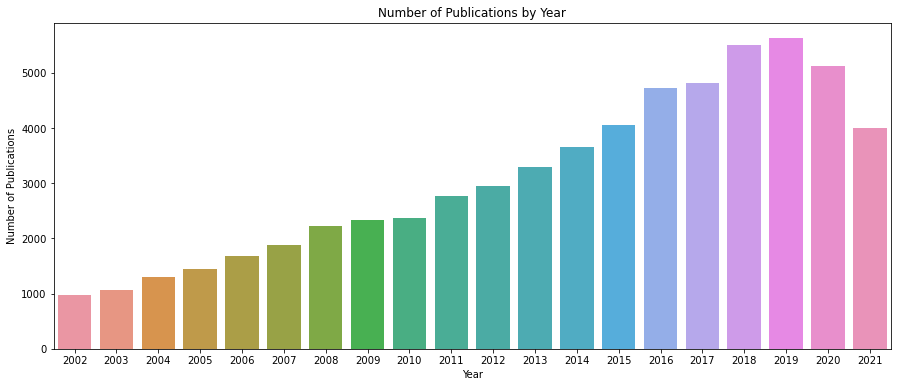

In [4]:
# Making a bar graph of the number of manga publications for each year(only the top 20 years with the most publications)

# dropping entries where there are missing values in the year column 
df_year = df.dropna(subset=['year'])

# Removing the decimal point in the year values by converting the year floats to ints
df_year['year'] = df_year['year'].apply(np.int64)

# Gives us a series where the index of the series is the year value, and the data is the count of how many entries in df has that year
# Basically tells us the number of publications for each year
pubByYearSeries = df_year['year'].value_counts()

# Creates a dataframe using the index of the pubByYearSeries to populate the Year and the values as the Number of Publications col 
pubByYear = pd.DataFrame({'Year':pubByYearSeries.index, 'Number of Publications':pubByYearSeries.values})

# Sorts the df by the number of publications, since we only want to show the top 20 years with the highest publication counts
pubByYear = pubByYear.sort_values(by =['Number of Publications'], ascending=False)

fig, ax = plt.subplots()
# Generating the bar plot, but only for the years with the top 20 publication counts, otherwise the plot would be unreadable
sns.barplot(x="Year", y="Number of Publications", data=pubByYear[:20], ax=ax).set(title='Number of Publications by Year')

# Sets the size so the x axis labels aren't squished together
fig.set_size_inches(15, 6)

#### Distribution of Ratings

In [5]:
# Same process that we did with pubByYear. This will give us a df where we'll have a rating column, and then another column 
# that tells us the number of publications/entries in our df with that rating
pubByRating = df['rating'].value_counts().to_frame().reset_index().rename(columns={"index": "rating", "rating": "Number of Publications"})

# Sorts the df so that we see the ratings with the most number of entries first
pubByRating.sort_values(by=['Number of Publications'],ascending=False)

# We can see that 3.8 is the most popular rating given to mangas. 

,rating,Number of Publications
0,3.8,2453
1,3.7,2445
2,3.9,2442
3,4.0,2377
4,3.6,2370
5,4.1,2282
6,3.5,2265
7,3.4,2072
8,4.2,2063
9,3.3,1820


In [6]:
# Lets also sort the pubByRating df by rating to see how high ratings are distributed

# Sorts the df so that we see the highest ratings first
pubByRating.sort_values(by=['rating'],ascending=False)

# We can see that the highest rating ever given to mangas on Anime-Planet is 4.7, with only 37 entries. I assume this is on a scale of 0-5, 
# so the highest possible rating should be a 5 but understandbly that would be hard to attain, since the rating is the average of all ratings. 

,rating,Number of Publications
19,4.7,37
16,4.6,327
14,4.5,782
12,4.4,1320
10,4.3,1802
8,4.2,2063
5,4.1,2282
3,4.0,2377
2,3.9,2442
0,3.8,2453


In [ ]:
# Lets plot the density plot for ratings! 
fig, ax = plt.subplots()

sns.kdeplot(df['rating'], shade=True).set(title='Density Plot for Ratings')

# Sets the size
fig.set_size_inches(8, 6)

##### From the density plot, we can see that most of the ratings given to publications fall around 3.8, and the number of entries are fewer as you travel to either of the spectrum(2.5 and 5). This plot looks like a bell curve, except the peak of the bell curve is rough instead of smooth like a normal bell curve. 

In [ ]:
# Let's see the publications with the highest ratings 

df_highest_ratings = df.sort_values(by=['rating'],ascending=False).head(20)

df_highest_ratings

The results are interesting because I only recognize 3 titles in the top 20 highest rated manga. Although, I don't read manga much--I mainly read manhua and manhwa, but one of the titles I do recognize is Roxana. I was suprised it made it into the list because it's a relatively new manhwa, and definitely not as popular as the popular manhwas(such as Who Made Me a Princess). So, I think some publications with high ratings simply have high ratings because they're not as popular so less users are rating them, and as a result the rating is an average rating of users that like the manga, and not necessarily indicative of the manga's quality. Roxana, in my opinion, does not deserve a 4.7. So a reccomender system that just spits out the highest rated entries would not be very useful, because of the factors that affect a publication's rating is not necessarily due to the quality of the actual publication. I think, to make the ratings more accurate, I would need access to how many users submitted a rating to achieve that rating for a publication. 

In [ ]:
# With this, and with the possible limitations of ratings in mind, let's still explore the top 100 highest rated publications anyway. 

# Gets the entries with the top 100 ratings
df_highest_ratings_100 = df.sort_values(by=['rating'],ascending=False).head(100)

# Let's see when the top 100 publications were published 

# dropping entries where there are missing values in the year column 
df_highest_ratings_100 = df_highest_ratings_100.dropna(subset=['year'])

# Removing the decimal point in the year values by converting the year floats to ints
df_highest_ratings_100['year'] = df_highest_ratings_100['year'].apply(np.int64)

# Gives us a series where the index of the series is the year value, and the data is the count of how many entries in df has that year
# Basically tells us the number of publications for each year
pubByYearSeries = df_highest_ratings_100['year'].value_counts()

# Creates a dataframe using the index of the pubByYearSeries to populate the Year and the values as the Number of Publications col 
pubByYear = pd.DataFrame({'Year':pubByYearSeries.index, 'Number of Publications':pubByYearSeries.values})

fig, ax = plt.subplots()

sns.barplot(x="Year", y="Number of Publications", data=pubByYear, ax=ax, order=pubByYear.sort_values('Number of Publications').Year).set(title='Number of Publications by Year For the Top 100 Highest Rated Publications')

fig.set_size_inches(15, 6)

# From the bar plot we can see that the most of the publications with high ratings came from 2020, then 2017 and 2021. 

#### What are the Most Common Genre/Tags? 

In [ ]:
# Dropping rows in the df where the tags are missing
tagsCol = df.dropna(subset=['tags'])

# Get the tags column 
tagsCol = df.loc[:,"tags"]

# dictionary where the key is the tag/genre, and the values are the count of how many times that genre appears in the df
tagsCount = {}

# Loop through each entry in the tagCol, where each entry is a list of tags. For each value in the list of tags, 
# if it's already in tagsCount, I increment the value associated with that key/tag/genre by 1. If not, I set it to 1. 
for tags in tagsCol:
    # each entry is actually a stringified list, so to convert it back to an actual list I use literal_eval
    tags = literal_eval(tags)
    for tag in tags:
        tagsCount[tag] = 1 + tagsCount.get(tag, 0)

# Create a df using the tagsCount dictionary. The df will contain a genre column, and a "Number of Publications" col, 
# which represents how many times that genre showed up inside the tags list of an entry inside the dataframe
pubByGenre = pd.DataFrame({'Genre':tagsCount.keys(), 'Number of Publications':tagsCount.values()})

fig, ax = plt.subplots()

sns.barplot(x="Genre", y="Number of Publications", data=pubByGenre[:30], ax=ax, order=pubByGenre[:30].sort_values('Number of Publications').Genre).set(title='Number of Publications Per Genre')

fig.set_size_inches(20, 6)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

##### From the bar plot, we can see that the most common genre/tag is romance, followed by comedy, BL, and action. The least common genre is xianxia and disability. I'm suprised Shounen is lower than Romance and BL. Well, Romance being high can make sense because Shounen and Romance aren't mutually exclusive, and since a manga can have multiple tags, I feel like a good number of mangas would be tagged with Romance even if romance isn't the main focus of the plot. BL being higher than Shounen is a bit suprising because I think BL caters to a largely female audience, and most manga readers are male. According to <a href="https://www.animenewsnetwork.com/news/2019-04-22/shueisha-reveals-new-circulation-numbers-demographics-for-its-manga-magazines/.145991">Shueisha </a>, 67.5% of readers are men and 32.5% of readers are women (data from 2018).

In [ ]:
# Let's see what genre's are most common in publications with the highest ratings. I imagine it would be similar to the graph that
# shows us the most common genres overall, because authors would be inclined to produce publications that are in-demand. 

# Dropping rows in the df where the tags are missing. We're using the df_highest_ratings_100 df that we made earlier, which contains
# the top 100 entries with the highest ratings
tagsCol = df_highest_ratings_100.dropna(subset=['tags'])

# Get the tags column 
tagsCol = df_highest_ratings_100.loc[:,"tags"]

# dictionary where the key is the tag/genre, and the values are the count of how many times that genre appears in the df
tagsCount = {}

# Loop through each entry in the tagCol, where each entry is a list of tags. For each value in the list of tags, 
# if it's already in tagsCount, I increment the value associated with that key/tag/genre by 1. If not, I set it to 1. 
for tags in tagsCol:
    # each entry is actually a stringified list, so to convert it back to an actual list I use literal_eval
    tags = literal_eval(tags)
    for tag in tags:
        tagsCount[tag] = 1 + tagsCount.get(tag, 0)

# Create a df using the tagsCount dictionary. The df will contain a genre column, and a "Number of Publications" col, 
# which represents how many times that genre showed up inside the tags list of an entry inside the dataframe
pubByGenre = pd.DataFrame({'Genre':tagsCount.keys(), 'Number of Publications':tagsCount.values()})

fig, ax = plt.subplots()

sns.barplot(x="Genre", y="Number of Publications", data=pubByGenre[:30], ax=ax, order=pubByGenre[:30].sort_values('Number of Publications').Genre).set(title='Number of Publications by Genre for the Top 100 Highest Rated Publications')

fig.set_size_inches(20, 6)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


### Part 4: Generating the Recommender System

##### <a href="https://www.engati.com/glossary/recommendation-systems"> Recommendation Systems </a> are computer programs that suggest recommendations to users depending on some criteria. For my recommendation system, I will be using content-based filtering, which suggests recommendations based on the item metadata. The main idea is if a user likes an item, then the user will also like items similar to it.

### Recommender System Using Tags

In [ ]:
# I will be using the title and tags column as features to build the recommendation system. 

# Currently just using the tags column to build the system. If there is time I'll incorporate the description and/or title column. 

# Dropping entries where there are missing values in the description or tags column 
# Only using the first 5000 entries because the Jupyter kernel dies with too many entries
mangas_df = df.dropna(subset=['tags', 'title']).head(5000)

# We'll be using the tag feature/column to generate the recommender 
features = ["tags"]

# cleaning the data by converting everything to lowercase and removing spaces 
for feature in features:
    mangas_df[feature] = mangas_df[feature].str.replace(' ','').str.lower()

# The ast.literal_eval method can safely evaluate strings containing Python values from unknown sources without us having to parse the values. 
for feature in features:
    mangas_df[feature] = mangas_df[feature].apply(literal_eval)
    
# create a soup containing the metadata extracted from the input to be put into the vectorizer
def create_soup(features):
    return ' '.join(features['tags'])

mangas_df["soup"] = mangas_df.apply(create_soup, axis=1)

print(mangas_df["soup"].head())


In [ ]:
# Our manga recommendation engine works by suggesting mangas to the user based on the metadata information. 
# The similarity between the mangas  is calculated and then used to make recommendations.

# CountVectorizer counts the frequency of each word and outputs a 2D vector containing frequencies.
count_vectorizer = CountVectorizer(stop_words="english")
count_matrix = count_vectorizer.fit_transform(mangas_df["soup"])

#print(count_matrix.shape)

# we use the cosine similarity score as this is just the dot product of the vector output by the CountVectorizer.
cosine_sim2 = cosine_similarity(count_matrix, count_matrix) 
#print(cosine_sim2.shape)

# Creates a series where the title is mapped to index of the mangas_df. 
# Using this, we can find the title of the movie based on the index.
indices = pd.Series(mangas_df.index, index=mangas_df["title"]).drop_duplicates()


In [ ]:
indices

In [ ]:
# Function that returns 10 recommendations given the title of a manga
def get_recommendations(title, cosine_sim=cosine_sim2):
    # gets the index into the mangas_df using the title 
    idx = indices[title]
    # Get the list of similarity scores of the manga concerning all the mangas in the df
    # Create tuples with the first element being the index and the second element is the cosine similarity score
    # (a, b) where a is index of manga, b is similarity_scores
    similarity_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the list of tuples in descending order based on the similarity score.
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # We get the top 10 entries from the sorted list of tuples. Excluding the 0th element bc that's the original manga itself
    similarity_scores = similarity_scores[1:11]
    
    # Extracting the index value of the mangas from the tuples
    mangas_indices = [ind[0] for ind in similarity_scores]
    
    # Using the index to index into the mangas_df to retrieve the name of the similar mangas
    mangas = mangas_df["title"].iloc[mangas_indices]
    return mangas

print("Roxana")
print(get_recommendations("Roxana", cosine_sim2))

##### The recommender appears to be working as expected. Roxana is a manhwa in the villainess genre, and although I don't recognize any titles that were recommended, just looking at the titles of the mangas, they appear to be similar to Roxana. 

### Part 5: Conclusions and Further Exploration 

In this tutorial, we explored the Anime-Planet dataset on mangas using using the data science pipeline and generated a recommender system using this dataset. As a result of my analysis, I found some suprising results, such as what the most common genre/tags of mangas are, what years were the most mangas published, and what genre/tags are associated with the highest rated titles. On the other hand, while doing my analysis, I also noticed the limitations of this dataset--because high ratings does not necessarily indicate popularity or quality of the manga. A dataset that includes the number of views for a particular publication would be a better indicator of popularity/quality than ratings, because as I mentioned before, some publications may just have high ratings because not many users have rated it. Consequently, that's a factor we need to keep in mind when interpreting the results of this dataset. So further exploration would include finding a dataset that also include views for mangas and merging it with this dataframe. As for the recommender system, I thought the best type of recommender system for this dataset would be a content based one, because it just intuively makes sense, a reader would be inclined to like mangas that are similar to each other. If we could find user data and use that in tandem with our current dataset, we could possibly build a system that is generated by analyzing the user's behavior and the demographics of users similar to each other. Lastly, for my recommender system, I only used the tags to generate the words to feed into the CountVectorizers, but to make the recommender more tailored, we could possibly also include the title and description of the manga as well. Although that may lead to overfitting, but we'll have to see. 